<a href="https://colab.research.google.com/github/KzBrain/project/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm as tqdm
from torch.utils.data import DataLoader
import torchvision.models as models

In [2]:
%matplotlib inline

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # изменение размера изображений до 224x224
    transforms.Grayscale(3),  # преобразование изображений в трёхканальный формат (RGB)
    transforms.ToTensor(),  # преобразование изображений в тензоры
    transforms.Normalize((0.5,), (0.5,))  # нормализация изображений
])

In [4]:
train_dataset = tv.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15742340.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481434.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4386794.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9789583.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

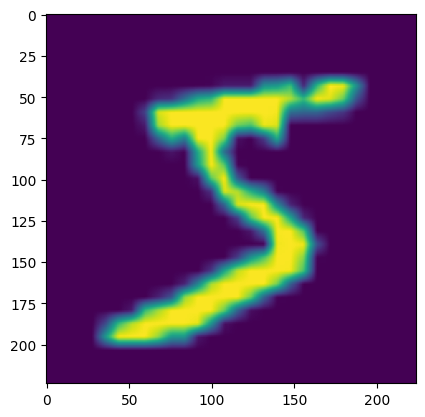

In [8]:
train_dataset[0][0].numpy()[0].shape
plt.imshow(train_dataset[0][0].numpy()[0])

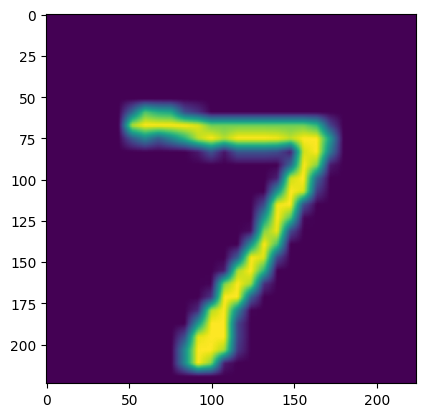

In [9]:
test_dataset[0][0].numpy()[0].shape
plt.imshow(test_dataset[0][0].numpy()[0])

In [10]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [11]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [12]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

In [13]:
loss_fn = nn.CrossEntropyLoss()

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
!pip install tqdm
from tqdm import tqdm

In [18]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    # Оборачиваем train_loader в tqdm
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Обновляем информацию в прогресс-баре
        progress_bar.set_postfix(loss=loss.item())

    # Печать средней потери за эпоху
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

print('Finished Training')

Epoch 1/5: 100%|██████████| 938/938 [05:10<00:00,  3.03it/s, loss=0.25]


Epoch [1/5], Loss: 0.0660


Epoch 2/5: 100%|██████████| 938/938 [04:55<00:00,  3.17it/s, loss=0.00501]


Epoch [2/5], Loss: 0.0365


Epoch 3/5: 100%|██████████| 938/938 [04:55<00:00,  3.18it/s, loss=0.039]


Epoch [3/5], Loss: 0.0253


Epoch 4/5: 100%|██████████| 938/938 [04:45<00:00,  3.29it/s, loss=0.000443]


Epoch [4/5], Loss: 0.0223


Epoch 5/5: 100%|██████████| 938/938 [04:34<00:00,  3.41it/s, loss=0.446]

Epoch [5/5], Loss: 0.0207
Finished Training


In [19]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
  for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Epoch 5/5: 100%|██████████| 938/938 [03:10<00:00,  4.93it/s]

Accuracy of the network on the 10000 test images: 98.96%
